In [1]:
# Goal: Use LTE relation to estimate optical depth for 5577 from 6300 optical depth
import sys, os
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds

In [4]:
def optical_depth_ratio(tau_6300, temperature):
    g_2 = 1
    g_1 = 5
    E2 = 48620.30533 # in K
    E1 = 22830.462395 # in K
    E0 = 0
    return g_2/g_1 * oxygen.RAD_DECAY_RATE_5577 / oxygen.RAD_DECAY_RATE_6300 * 5577**3 / 6300**3 * np.exp(-E1/temperature) * (1-np.exp(-E2/temperature)/np.exp(-E1/temperature))/(1-np.exp(-E1/temperature))

In [6]:
def beta(tau):
    return (1-np.exp(-tau))/tau

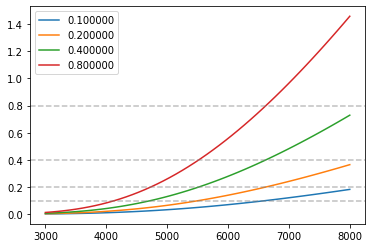

In [15]:
temp = np.linspace(3000, 8000)
taus = [0.1, 0.2, 0.4, 0.8]
for tau in taus:
    tau5577 = optical_depth_ratio(tau, temp)*tau
    plt.plot(temp, tau5577, label='%f' % tau)
plt.legend()
for t in taus:
    plt.axhline(t, alpha=0.5, ls='--', color='grey')

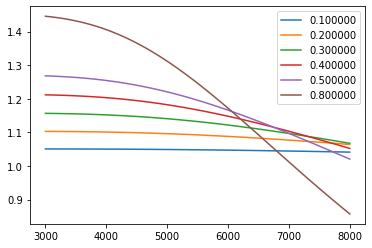

In [14]:
temp = np.linspace(3000, 8000)
for tau in [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]:
    tau5577 = optical_depth_ratio(tau, temp)*tau
    plt.plot(temp, beta(tau5577*tau)/beta(tau), label='%f' % tau)
plt.legend()

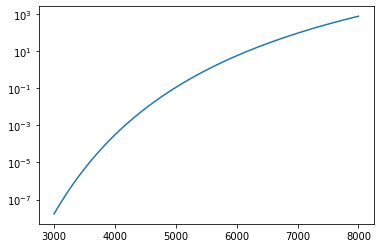

In [19]:
# line ratio between 9265 and 6300 as function of temperature
temp = np.linspace(3000, 8000)
A9265 = 1.48e7
A6300 = 5.63e-3
g9265 = 7
g6300 = 5
E9265 = 12.078 #eV
E6300 = 1.967 #eV
k_B = 8.6e-5 # eV/K

ratio = A9265/A6300 * 6300/9265 * np.exp(-E9265/k_B/temp) / np.exp(-E6300/k_B/temp)
plt.plot(temp, ratio)
plt.yscale('log')

In [30]:
def calculate_optical_depth_lte_other(tau_6300, temp, line):
    """
    Calculate the optical depth of other O I lines in relation to the optical depth of the 6300 line
    """
    k_B = 8.617333262e-5 # eV/K
    if line == 7771:
        Ax = 3.69e7
        E0 = 9.1460911 # eV
        E1 = 10.7409314 # eV
        g0 = 5
        g1 = 7
    elif line == 9265:
        Ax = 1.48e+07
        E0 = 10.7409314
        E1 = 12.0786294
        g0 = 7
        g1 = 7
    elif line == 6158:
        Ax = 7.62e+06
        E0 = 10.7409314
        E1 = 12.7536973
        g0 = 7
        g1 = 9
    A6300 = 5.53e-3
    E6300 = 1.967 # eV
    g_g = 9 # ground state
    g_u = 5 # E6300 state

    pre_factor = (g1/g0)/(g_u/g_g) * Ax / A6300 * (line)**3 / 6300**3
    return tau_6300 * pre_factor * g0/g_g * np.exp(-E0/k_B/temp) * (1-(np.exp(-E1/k_B/temp)/np.exp(-E0/k_B/temp)))/(1-np.exp(-E6300/k_B/temp))

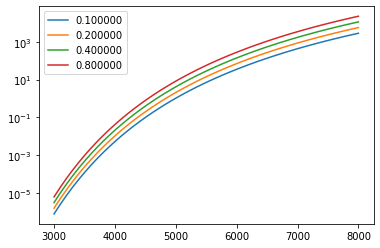

In [24]:
temp = np.linspace(3000, 8000)
taus = [0.1, 0.2, 0.4, 0.8]
for tau in taus:
    tau_7771 = calculate_optical_depth_lte_other(tau, temp, 7771)
    plt.plot(temp, tau_7771, label='%f' % tau)
plt.legend()
plt.yscale('log')

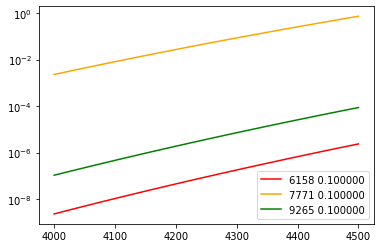

In [33]:
A7771 = 3.69e7
A6300 = 5.63e-3
A9265 = 1.48e7
A6158 = 7.62e+06
g7771 = 7
g6300 = 5
g9265 = 7
g6158 = 9
E7771 = 10.7409314 #eV
E6300 = 1.967 #eV
E9265 = 12.078 #eV
E6158 = 12.7536973 # eV
k_B = 8.6e-5 # eV/K

#temp = np.linspace(3000, 8000)
temp = np.linspace(4000, 4500)
taus = [0.1]
for tau in taus:
    tau_7771 = calculate_optical_depth_lte_other(tau, temp, 7771)
    tau_9265 = calculate_optical_depth_lte_other(tau, temp, 9265)
    tau_6158 = calculate_optical_depth_lte_other(tau, temp, 6158)
    #ratio = A9265/A6300 * 6300/9265 * np.exp(-E9265/k_B/temp) / np.exp(-E6300/k_B/temp)
    ratio6158 = A6158/A6300 * 6300/6158 * np.exp(-E6158/k_B/temp) / np.exp(-E6300/k_B/temp) * tau_6158/tau
    ratio7771 = A7771/A6300 * 6300/7771 * np.exp(-E7771/k_B/temp) / np.exp(-E6300/k_B/temp) * tau_7771/tau
    ratio9265 = A9265/A6300 * 6300/9265 * np.exp(-E9265/k_B/temp) / np.exp(-E6300/k_B/temp) * tau_9265/tau
    plt.plot(temp, ratio6158, label='6158 %f' % tau, color='red')
    plt.plot(temp, ratio7771, label='7771 %f' % tau, color='orange')
    plt.plot(temp, ratio9265, label='9265 %f' % tau, color='green')
    
plt.legend()
plt.yscale('log')

In [35]:
import numba, collections
XYZ = collections.namedtuple('XYZ', 'x y z')
def gen_func(a):
    @numba.njit
    def func(b,c):
        return a.x + b*a.y + c*a.z
    return func
xyz_func = gen_func(XYZ(1,2,3))
xyz_func(2,3)

14